# Dependencies

In [1]:
# %pip install pyxdf && echo "Installation Successful (pyxdf)" || echo "Installation Failed (pyxdf)"
# import sys
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip list --outdated --format=freeze | grep -v '^\-e' | cut -d = -f 1 | xargs -n1 {sys.executable} -m pip install -U

In [2]:
# # In a Jupyter cell - using ! to run shell commands
# !pip install --upgrade numpy pandas matplotlib scikit-learn seaborn

In [3]:
import pyxdf
import pandas as pd
import numpy as np
import os
import glob
import re
import shutil
import io
import matplotlib.pyplot as plt
import pprint
from scipy.interpolate import interp1d

# F(x) XDF Data Processing

In [4]:
# ===========================================================
# Channel Label Extraction
# ===========================================================

def extract_channel_labels(stream):
    try:
        # Navigate the nested metadata structure to find channel entries
        channel_entries = stream['info']['desc'][0]['channels'][0]['channel']

        # Handle both single channel (dict) and multiple channels (list of dicts)
        if not isinstance(channel_entries, list):
            channel_entries = [channel_entries]

        labels, types, units = [], [], []

        # Extract information from each channel entry
        for i, ch in enumerate(channel_entries):
            # Get label (try 'label' first, fallback to 'name', finally generic)
            label = ch.get('label', ch.get('name', [f"Channel {i}"]))[0]
            signal_type = ch.get('type', [''])[0]
            unit = ch.get('unit', [''])[0]

            labels.append(label)
            types.append(signal_type)
            units.append(unit)

        return labels, types, units

    except (KeyError, IndexError, TypeError):
        # Fallback when metadata is missing or malformed
        # Use channel_count from stream info to generate generic labels
        num_channels = stream['info'].get('channel_count', ['0'])[0]
        try:
            num_channels = int(num_channels)
        except ValueError:
            num_channels = 1

        # Generate generic channel labels
        labels = [f"Channel {i}" for i in range(num_channels)]
        return labels, [''] * num_channels, [''] * num_channels

# ===========================================================
# String Normalization for Robust Matching
# ===========================================================

def normalize_string(s):
     return s.strip().lower()

# ===========================================================
# Channel Filtering with Robust Matching
# ===========================================================

def filter_stream_channels_robust(stream, channel_names):

    # Extract all available channel information from the stream
    labels, types, units = extract_channel_labels(stream)

    # Create a mapping from normalized names to original indices
    # This allows O(1) lookup for each requested channel
    normalized_labels = {normalize_string(label): i for i, label in enumerate(labels)}

    # Normalize the requested channel names for comparison
    normalized_requests = [normalize_string(name) for name in channel_names]

    # Find indices of matching channels
    matching_indices = []
    matched_names = []
    for req in normalized_requests:
        if req in normalized_labels:
            idx = normalized_labels[req]
            matching_indices.append(idx)
            matched_names.append(labels[idx])  # Keep original label (not normalized)

    # Return None if no channels matched
    if not matching_indices:
        return None

    # Create filtered stream with only the selected channels
    filtered_stream = {
        'info': stream['info'].copy(),  # Shallow copy of metadata
        'time_series': stream['time_series'][:, matching_indices],  # Select columns
        'time_stamps': stream.get('time_stamps', None),  # Preserve timestamps
    }

    # Update metadata to reflect the filtered channel set
    try:
        desc = filtered_stream['info']['desc'][0]
        if 'channels' in desc and 'channel' in desc['channels'][0]:
            original_channels = desc['channels'][0]['channel']
            if isinstance(original_channels, list):
                # Keep only the channel metadata entries that matched
                filtered_channels = [original_channels[i] for i in matching_indices]
                filtered_stream['info']['desc'][0]['channels'][0]['channel'] = filtered_channels
        # Update the channel count in metadata
        filtered_stream['info']['channel_count'] = [str(len(matching_indices))]
    except Exception:
        # If metadata update fails, continue (data is still filtered correctly)
        pass

    return filtered_stream

# ===========================================================
# Multi-Stream Selection with Diagnostics
# ===========================================================

def select_streams_by_name(streams, selection_dict, verbose=True):

    selected_streams = []

    # Create a lookup table: normalized name -> (original stream, original name)
    stream_lookup = {}
    for stream in streams:
        stream_name = stream['info']['name'][0]
        normalized_name = normalize_string(stream_name)
        stream_lookup[normalized_name] = (stream, stream_name)

    # Print available streams if verbose mode is enabled
    if verbose:
        print(f"\n🔍 Available streams ({len(streams)}):")
        for norm_name, (_, orig_name) in stream_lookup.items():
            print(f"  '{orig_name}'")
        print()

    # Process each requested stream
    for requested_name, channels in selection_dict.items():
        normalized_request = normalize_string(requested_name)

        if "polar" in normalized_request:
            # Search for a stream with "Polar H10" in original name (case-insensitive)
            matching_stream = None
            for norm_name, (stream, orig_name) in stream_lookup.items():
                if "polar h10" in orig_name.lower():
                    matching_stream = (stream, orig_name)
                    break
            if matching_stream:
                stream, original_name = matching_stream
                if verbose:
                    print(f"   Found stream matching 'Polar H10': '{original_name}'")
                filtered_stream = filter_stream_channels_robust(stream, channels)

                if filtered_stream is not None:
                    labels, _, _ = extract_channel_labels(filtered_stream)
                    if verbose:
                        print(f"   Matched {len(labels)} channel(s): {labels}")
                    selected_streams.append(filtered_stream)
                else:
                    if verbose:
                        print(f"   No matching channels found in '{original_name}'")
                continue
        # Check if the stream exists in our lookup
        if normalized_request in stream_lookup:
            stream, original_name = stream_lookup[normalized_request]
            if verbose:
                print(f"   Found stream: '{original_name}'")
                print(f"   Searching for channels: {channels}")

            # Filter the stream to include only requested channels
            filtered_stream = filter_stream_channels_robust(stream, channels)

            if filtered_stream is not None:
                # Successfully found at least one matching channel
                labels, _, _ = extract_channel_labels(filtered_stream)
                if verbose:
                    print(f"   Matched {len(labels)} channel(s): {labels}")
                selected_streams.append(filtered_stream)
            else:
                # Stream was found, but none of the requested channels matched
                if verbose:
                    print(f"   No matching channels found in '{original_name}'")
        else:
            # Stream name didn't match any available streams
            if verbose:
                print(f"Stream not found: '{requested_name}'")
                print(f"   (normalized as: '{normalized_request}')")

    # Print summary
    if verbose:
        print(f"\n Total streams selected: {len(selected_streams)}\n")

    return selected_streams

# ===========================================================
# Stream-to-DataFrame Conversion with Synchronization
# ===========================================================

def streams_to_dataframe(streams, resample=True, target_freq=1.0, use_timestamps=True, n=0):

    # Handle empty input
    if not streams:
        print("No streams provided to streams_to_dataframe()")
        return pd.DataFrame()

    all_data = []

    # Process each stream individually
    for stream in streams:
        # Extract stream metadata
        name = stream['info']['name'][0]
        data = stream['time_series']
        ts = stream.get('time_stamps')
        labels, _, _ = extract_channel_labels(stream)

        # Safety check: ensure we have labels for all data columns
        num_channels = data.shape[1]
        labels = labels[:num_channels]

        # Determine time column
        if use_timestamps and ts is not None:
            time_col = ts  # Use original timestamps
        else:
            # Generate synthetic timestamps assuming constant sampling rate
            time_col = np.arange(len(data)) / target_freq

        # Create DataFrame for this stream with prefixed column names
        df_part = pd.DataFrame(data, columns=[f"{name}_{label}" for label in labels])
        df_part.insert(0, "XDFTime", time_col)  # CHANGED: Rename to XDFTime
        all_data.append(df_part)

    # Determine the overlapping time range across all streams
    # Use the latest start time and earliest end time
    min_t = max(df["XDFTime"].min() for df in all_data)  # CHANGED: XDFTime
    max_t = min(df["XDFTime"].max() for df in all_data)  # CHANGED: XDFTime

    # Create the new time grid
    if resample:
        # Uniform grid at target_freq Hz
        new_time = np.arange(min_t, max_t, 1.0 / target_freq)
    else:
        # Use the union of all original timestamps (sorted and unique)
        new_time = sorted(set(np.concatenate([df["XDFTime"].values for df in all_data])))  # CHANGED: XDFTime

    # Initialize the merged data dictionary
    merged = {"XDFTime": new_time}  # CHANGED: XDFTime

    # Interpolate each stream's channels onto the new time grid
    for df_part in all_data:
        for col in df_part.columns:
            if col == "XDFTime":  # CHANGED: XDFTime
                continue  # Skip the time column itself

            # Create interpolation function
            f = interp1d(df_part["XDFTime"], df_part[col],  # CHANGED: XDFTime
                        fill_value="extrapolate",
                        bounds_error=False)

            # Apply interpolation to new time grid
            merged[col] = f(new_time)

    # Create the final combined DataFrame
    df = pd.DataFrame(merged)

    # REMOVED: Time column generation here - we'll add it after truncation

    # Truncate n samples from start and end if requested
    if n > 0:
        if len(df) > 2 * n:
            # Remove first n and last n rows
            df = df.iloc[n:-n].reset_index(drop=True)
        else:
            # Not enough data to truncate safely
            print(f"Warning: n={n} too large for dataset length {len(df)} — skipping truncation.")

    # ADD Time column AFTER truncation to ensure it starts from 0
    df.insert(0, "Time", np.arange(len(df)) / target_freq)

    return df
    
# def streams_to_dataframe(streams, resample=True, target_freq=1.0, use_timestamps=True, n=0):

#     # Handle empty input
#     if not streams:
#         print("No streams provided to streams_to_dataframe()")
#         return pd.DataFrame()

#     all_data = []

#     # Process each stream individually
#     for stream in streams:
#         # Extract stream metadata
#         name = stream['info']['name'][0]
#         data = stream['time_series']
#         ts = stream.get('time_stamps')
#         labels, _, _ = extract_channel_labels(stream)

#         # Safety check: ensure we have labels for all data columns
#         num_channels = data.shape[1]
#         labels = labels[:num_channels]

#         # Determine time column
#         if use_timestamps and ts is not None:
#             time_col = ts  # Use original timestamps
#         else:
#             # Generate synthetic timestamps assuming constant sampling rate
#             time_col = np.arange(len(data)) / target_freq

#         # Create DataFrame for this stream with prefixed column names
#         df_part = pd.DataFrame(data, columns=[f"{name}_{label}" for label in labels])
#         df_part.insert(0, "Time", time_col)
#         all_data.append(df_part)

#     # Determine the overlapping time range across all streams
#     # Use the latest start time and earliest end time
#     min_t = max(df["Time"].min() for df in all_data)
#     max_t = min(df["Time"].max() for df in all_data)

#     # Create the new time grid
#     if resample:
#         # Uniform grid at target_freq Hz
#         new_time = np.arange(min_t, max_t, 1.0 / target_freq)
#     else:
#         # Use the union of all original timestamps (sorted and unique)
#         new_time = sorted(set(np.concatenate([df["Time"].values for df in all_data])))

#     # Initialize the merged data dictionary
#     merged = {"Time": new_time}

#     # Interpolate each stream's channels onto the new time grid
#     for df_part in all_data:
#         for col in df_part.columns:
#             if col == "Time":
#                 continue  # Skip the time column itself

#             # Create interpolation function
#             f = interp1d(df_part["Time"], df_part[col],
#                         fill_value="extrapolate",
#                         bounds_error=False)

#             # Apply interpolation to new time grid
#             merged[col] = f(new_time)

#     # Create the final combined DataFrame
#     df = pd.DataFrame(merged)

#     # Truncate n samples from start and end if requested
#     if n > 0:
#         if len(df) > 2 * n:
#             # Remove first n and last n rows
#             df = df.iloc[n:-n].reset_index(drop=True)
#         else:
#             # Not enough data to truncate safely
#             print(f"Warning: n={n} too large for dataset length {len(df)} — skipping truncation.")

#     return df

# ===========================================================
# Post-Processing: Resampling
# ===========================================================

def resample_dataframe(data, target_freq=1.0, verbose=True):

    # Validate input - now check for XDFTime instead of Time
    if "XDFTime" not in data.columns:  # CHANGED: XDFTime
        raise ValueError("Input DataFrame must contain a 'XDFTime' column")  # CHANGED: XDFTime

    # Extract original time column (XDFTime)
    original_time = data["XDFTime"].values  # CHANGED: XDFTime

    if len(original_time) < 2:
        raise ValueError("DataFrame must have at least 2 time points for resampling")

    # Check original time spacing
    time_diffs = np.diff(original_time)
    tolerance = 1e-6
    is_equally_spaced = np.allclose(time_diffs, np.mean(time_diffs), atol=tolerance)

    if verbose:
        if is_equally_spaced:
            print("\n✓ Original time data is equally spaced.")
        else:
            print("\n⚠ Original time data is NOT equally spaced.")
        print(f"  Standard deviation of time differences: {np.std(time_diffs):.6f} seconds")

    # Create new uniform time grid for XDFTime
    new_xdftime = np.arange(original_time[0], original_time[-1], 1.0 / target_freq)

    # Helper function for interpolating a single column
    def interpolate_column(original_time, col_data, new_time):
        """Interpolate a single data column onto a new time grid."""
        if len(original_time) < 2:
            return np.full(len(new_time), np.mean(col_data))
        else:
            interp_func = interp1d(
                original_time,
                col_data,
                kind='linear',
                fill_value="extrapolate",
                bounds_error=False
            )
            return interp_func(new_time)

    # Resample each data column (excluding both Time and XDFTime columns)
    columns_to_resample = [col for col in data.columns if col not in ["Time", "XDFTime"]]  # CHANGED
    resampled_data = {}

    for col in columns_to_resample:
        col_data = data[col].values
        resampled_data[col] = interpolate_column(original_time, col_data, new_xdftime)

    # Create final resampled DataFrame
    final_dataset = pd.DataFrame(resampled_data)
    final_dataset.insert(0, "XDFTime", new_xdftime)  # CHANGED: XDFTime
    
    # REMOVED: Time column generation here - we'll add it after truncation in the main pipeline

    # Verify resampled time spacing for XDFTime
    resampled_time_diffs = np.diff(new_xdftime)
    is_resampled_equally_spaced = np.allclose(
        resampled_time_diffs,
        np.mean(resampled_time_diffs),
        atol=tolerance
    )

    if verbose:
        if is_resampled_equally_spaced:
            print("\n✓ Resampled XDFTime data is equally spaced.")  # CHANGED
        else:
            print("\n⚠ Resampled XDFTime data is NOT equally spaced.")  # CHANGED
        print(f"  Standard deviation of resampled XDFTime differences: {np.std(resampled_time_diffs):.6e} seconds")  # CHANGED

        print(f"\n📊 Dataset Summary:")
        print(f"  Shape: {final_dataset.shape} (rows × columns)")
        print(f"  Total data points: {final_dataset.size:,}")
        print(f"  XDFTime range: {new_xdftime[0]:.3f} - {new_xdftime[-1]:.3f} seconds")  # CHANGED
        print(f"  Duration: {new_xdftime[-1] - new_xdftime[0]:.3f} seconds")  # CHANGED
        print(f"  Sampling rate: {target_freq} Hz")
        print(f"  Time step: {1.0/target_freq:.6f} seconds")

    return final_dataset
    
# def resample_dataframe(data, target_freq=1.0, verbose=True):

#     # Validate input
#     if "Time" not in data.columns:
#         raise ValueError("Input DataFrame must contain a 'Time' column")

#     # Extract original time column
#     original_time = data["Time"].values

#     if len(original_time) < 2:
#         raise ValueError("DataFrame must have at least 2 time points for resampling")

#     # Check original time spacing
#     time_diffs = np.diff(original_time)
#     tolerance = 1e-6
#     is_equally_spaced = np.allclose(time_diffs, np.mean(time_diffs), atol=tolerance)

#     if verbose:
#         if is_equally_spaced:
#             print("\n✓ Original time data is equally spaced.")
#         else:
#             print("\n⚠ Original time data is NOT equally spaced.")
#         print(f"  Standard deviation of time differences: {np.std(time_diffs):.6f} seconds")

#     # Create new uniform time grid
#     new_time = np.arange(original_time[0], original_time[-1], 1.0 / target_freq)

#     # Helper function for interpolating a single column
#     def interpolate_column(original_time, col_data, new_time):
#         """Interpolate a single data column onto a new time grid."""
#         if len(original_time) < 2:
#             return np.full(len(new_time), np.mean(col_data))
#         else:
#             interp_func = interp1d(
#                 original_time,
#                 col_data,
#                 kind='linear',
#                 fill_value="extrapolate",
#                 bounds_error=False
#             )
#             return interp_func(new_time)

#     # Resample each data column
#     columns_to_resample = [col for col in data.columns if col != "Time"]
#     resampled_data = {}

#     for col in columns_to_resample:
#         col_data = data[col].values
#         resampled_data[col] = interpolate_column(original_time, col_data, new_time)

#     # Create final resampled DataFrame
#     final_dataset = pd.DataFrame(resampled_data)
#     final_dataset.insert(0, "Time", new_time)

#     # Verify resampled time spacing
#     resampled_time_diffs = np.diff(new_time)
#     is_resampled_equally_spaced = np.allclose(
#         resampled_time_diffs,
#         np.mean(resampled_time_diffs),
#         atol=tolerance
#     )

#     if verbose:
#         if is_resampled_equally_spaced:
#             print("\n✓ Resampled time data is equally spaced.")
#         else:
#             print("\n⚠ Resampled time data is NOT equally spaced.")
#         print(f"  Standard deviation of resampled time differences: {np.std(resampled_time_diffs):.6e} seconds")

#         print(f"\n📊 Dataset Summary:")
#         print(f"  Shape: {final_dataset.shape} (rows × columns)")
#         print(f"  Total data points: {final_dataset.size:,}")
#         print(f"  Time range: {new_time[0]:.3f} - {new_time[-1]:.3f} seconds")
#         print(f"  Duration: {new_time[-1] - new_time[0]:.3f} seconds")
#         print(f"  Sampling rate: {target_freq} Hz")
#         print(f"  Time step: {1.0/target_freq:.6f} seconds")

#     return final_dataset

# ===========================================================
# Post-Processing: Truncation
# ===========================================================

def truncate_dataframe(data, n=0, verbose=True):

    if n < 0:
        raise ValueError(f"n must be non-negative, got n={n}")

    if n == 0:
        if verbose:
            print("\nℹ No truncation performed (n=0)")
        return data

    original_length = len(data)

    if original_length <= 2 * n:
        if verbose:
            print(f"\n⚠ Warning: n={n} is too large for dataset length {original_length} — skipping truncation.")
            print(f"   Minimum length required: {2*n + 1} (to remove {n} from each end)")
        return data

    if verbose:
        print(f"\n📊 Truncation Summary:")
        print(f"  Original shape: {data.shape}")
        print(f"  Removing {n} rows from start and end ({2*n} total)")

    truncated_data = data.iloc[n:-n].reset_index(drop=True)
    
    # REGENERATE Time column to ensure it starts from 0 after truncation
    if "Time" in truncated_data.columns:
        # Remove old Time column
        truncated_data = truncated_data.drop(columns=["Time"])
    # Add new Time column starting from 0
    target_freq = 1.0 / (truncated_data["XDFTime"].iloc[1] - truncated_data["XDFTime"].iloc[0]) if len(truncated_data) > 1 else 1.0
    truncated_data.insert(0, "Time", np.arange(len(truncated_data)) / target_freq)

    if verbose:
        print(f"  Final shape: {truncated_data.shape}")

        if "XDFTime" in truncated_data.columns:
            time_removed_start = data.iloc[n]["XDFTime"] - data.iloc[0]["XDFTime"]
            time_removed_end = data.iloc[-1]["XDFTime"] - data.iloc[-n-1]["XDFTime"]
            print(f"  XDFTime removed from start: {time_removed_start:.3f} seconds")
            print(f"  XDFTime removed from end: {time_removed_end:.3f} seconds")
            print(f"  New XDFTime range: {truncated_data['XDFTime'].iloc[0]:.3f} - {truncated_data['XDFTime'].iloc[-1]:.3f} seconds")
            print(f"  New Time range: {truncated_data['Time'].iloc[0]:.3f} - {truncated_data['Time'].iloc[-1]:.3f} seconds")  # Now starts at 0!

    return truncated_data
    
# def truncate_dataframe(data, n=0, verbose=True):

#     if n < 0:
#         raise ValueError(f"n must be non-negative, got n={n}")

#     if n == 0:
#         if verbose:
#             print("\nℹ No truncation performed (n=0)")
#         return data

#     original_length = len(data)

#     if original_length <= 2 * n:
#         if verbose:
#             print(f"\n⚠ Warning: n={n} is too large for dataset length {original_length} — skipping truncation.")
#             print(f"   Minimum length required: {2*n + 1} (to remove {n} from each end)")
#         return data

#     if verbose:
#         print(f"\n📊 Truncation Summary:")
#         print(f"  Original shape: {data.shape}")
#         print(f"  Removing {n} rows from start and end ({2*n} total)")

#     truncated_data = data.iloc[n:-n].reset_index(drop=True)

#     if verbose:
#         print(f"  Final shape: {truncated_data.shape}")

#         if "Time" in truncated_data.columns:
#             time_removed_start = data.iloc[n]["Time"] - data.iloc[0]["Time"]
#             time_removed_end = data.iloc[-1]["Time"] - data.iloc[-n-1]["Time"]
#             print(f"  Time removed from start: {time_removed_start:.3f} seconds")
#             print(f"  Time removed from end: {time_removed_end:.3f} seconds")
#             print(f"  New time range: {truncated_data['Time'].iloc[0]:.3f} - {truncated_data['Time'].iloc[-1]:.3f} seconds")

#     return truncated_data

# ===========================================================
# Diagnostic and Utility Functions
# ===========================================================

def print_stream_info(streams):
    print(f"\n{'='*60}")
    print(f"Found {len(streams)} stream(s):")
    print(f"{'='*60}\n")

    for stream in streams:
        name = stream['info']['name'][0]
        labels, types, units = extract_channel_labels(stream)

        print(f" Stream: {name}")
        print(f"   Channels ({len(labels)}):")

        for l, t, u in zip(labels, types, units):
            type_str = f"({t})" if t else ""
            unit_str = f"[{u}]" if u else ""
            print(f"      • {l} {type_str} {unit_str}".strip())

        print(f"{'-'*60}\n")


def get_copyable_format(streams):
    print("\n Copy this template and fill in your desired channels:\n")
    print("selection_dict = {")

    for stream in streams:
        name = stream['info']['name'][0]
        labels, _, _ = extract_channel_labels(stream)
        print(f'    "{name}": {labels},')

    print("}\n")

# ===========================================================
# Complete Pipeline: All-in-One Processing
# ===========================================================

def process_xdf_streams(streams, selection_dict, target_freq=50.0, truncate_n=0, verbose=True):

    if verbose:
        print("\n" + "="*70)
        print("XDF STREAM PROCESSING PIPELINE")
        print("="*70)
        print("\n📋 Configuration:")
        print(f"  Target frequency: {target_freq} Hz")
        print(f"  Truncation: {truncate_n} samples from each end")
        print(f"  Streams requested: {len(selection_dict)}")

    # STEP 1: Stream Selection
    if verbose:
        print("\n" + "-"*70)
        print("STEP 1: Stream Selection")
        print("-"*70)

    selected_streams = select_streams_by_name(streams, selection_dict, verbose=verbose)

    if not selected_streams:
        if verbose:
            print("\n❌ No streams selected. Check your selection_dict.")
        return pd.DataFrame()

    # STEP 2: Synchronization and Initial Processing
    if verbose:
        print("\n" + "-"*70)
        print("STEP 2: Synchronization and Resampling")
        print("-"*70)

    df = streams_to_dataframe(
        selected_streams,
        resample=True,
        target_freq=target_freq,
        use_timestamps=True,
        n=0
    )

    if df.empty:
        if verbose:
            print("\n❌ Empty DataFrame after synchronization.")
        return df

    if verbose:
        print(f"\n✓ Synchronized DataFrame created")
        print(f"  Shape: {df.shape}")
        print(f"  Time range: {df['Time'].iloc[0]:.3f} - {df['Time'].iloc[-1]:.3f} seconds")
        print(f"  Duration: {df['Time'].iloc[-1] - df['Time'].iloc[0]:.3f} seconds")

    # STEP 3: Final Resampling
    if verbose:
        print("\n" + "-"*70)
        print("STEP 3: Final Resampling Verification")
        print("-"*70)

    df_resampled = resample_dataframe(df, target_freq=target_freq, verbose=verbose)

    # STEP 4: Truncation
    if truncate_n > 0:
        if verbose:
            print("\n" + "-"*70)
            print("STEP 4: Edge Truncation")
            print("-"*70)

        df_final = truncate_dataframe(df_resampled, n=truncate_n, verbose=verbose)
    else:
        df_final = df_resampled
        # Ensure Time column starts from 0 even when no truncation
        if "Time" in df_final.columns:
            df_final = df_final.drop(columns=["Time"])
        df_final.insert(0, "Time", np.arange(len(df_final)) / target_freq)
        
        if verbose:
            print("\n" + "-"*70)
            print("STEP 4: Edge Truncation")
            print("-"*70)
            print("\nℹ Truncation skipped (truncate_n=0)")

    # Final Summary
    if verbose:
        print("\n" + "="*70)
        print("PROCESSING COMPLETE ✓")
        print("="*70)
        print(f"\n📊 Final Dataset Summary:")
        print(f"  Shape: {df_final.shape[0]:,} rows × {df_final.shape[1]} columns")
        print(f"  Time range: {df_final['Time'].iloc[0]:.3f} - {df_final['Time'].iloc[-1]:.3f} seconds")  # Now always starts at 0!
        print(f"  Duration: {df_final['Time'].iloc[-1] - df_final['Time'].iloc[0]:.3f} seconds")
        print(f"  Sampling frequency: {target_freq} Hz")
        print(f"  Columns: {list(df_final.columns)}")
        print("\n" + "="*70 + "\n")

    return df_final
    
# def process_xdf_streams(streams, selection_dict, target_freq=50.0, truncate_n=0, verbose=True):

#     if verbose:
#         print("\n" + "="*70)
#         print("XDF STREAM PROCESSING PIPELINE")
#         print("="*70)
#         print("\n📋 Configuration:")
#         print(f"  Target frequency: {target_freq} Hz")
#         print(f"  Truncation: {truncate_n} samples from each end")
#         print(f"  Streams requested: {len(selection_dict)}")

#     # STEP 1: Stream Selection
#     if verbose:
#         print("\n" + "-"*70)
#         print("STEP 1: Stream Selection")
#         print("-"*70)

#     selected_streams = select_streams_by_name(streams, selection_dict, verbose=verbose)

#     if not selected_streams:
#         if verbose:
#             print("\n❌ No streams selected. Check your selection_dict.")
#         return pd.DataFrame()

#     # STEP 2: Synchronization and Initial Processing
#     if verbose:
#         print("\n" + "-"*70)
#         print("STEP 2: Synchronization and Resampling")
#         print("-"*70)

#     df = streams_to_dataframe(
#         selected_streams,
#         resample=True,
#         target_freq=target_freq,
#         use_timestamps=True,
#         n=0
#     )

#     if df.empty:
#         if verbose:
#             print("\n❌ Empty DataFrame after synchronization.")
#         return df

#     if verbose:
#         print(f"\n✓ Synchronized DataFrame created")
#         print(f"  Shape: {df.shape}")
#         print(f"  Time range: {df['Time'].iloc[0]:.3f} - {df['Time'].iloc[-1]:.3f} seconds")
#         print(f"  Duration: {df['Time'].iloc[-1] - df['Time'].iloc[0]:.3f} seconds")

#     # STEP 3: Final Resampling
#     if verbose:
#         print("\n" + "-"*70)
#         print("STEP 3: Final Resampling Verification")
#         print("-"*70)

#     df_resampled = resample_dataframe(df, target_freq=target_freq, verbose=verbose)

#     # STEP 4: Truncation
#     if truncate_n > 0:
#         if verbose:
#             print("\n" + "-"*70)
#             print("STEP 4: Edge Truncation")
#             print("-"*70)

#         df_final = truncate_dataframe(df_resampled, n=truncate_n, verbose=verbose)
#     else:
#         df_final = df_resampled
#         if verbose:
#             print("\n" + "-"*70)
#             print("STEP 4: Edge Truncation")
#             print("-"*70)
#             print("\nℹ Truncation skipped (truncate_n=0)")

#     # Final Summary
#     if verbose:
#         print("\n" + "="*70)
#         print("PROCESSING COMPLETE ✓")
#         print("="*70)
#         print(f"\n📊 Final Dataset Summary:")
#         print(f"  Shape: {df_final.shape[0]:,} rows × {df_final.shape[1]} columns")
#         print(f"  Time range: {df_final['Time'].iloc[0]:.3f} - {df_final['Time'].iloc[-1]:.3f} seconds")
#         print(f"  Duration: {df_final['Time'].iloc[-1] - df_final['Time'].iloc[0]:.3f} seconds")
#         print(f"  Sampling frequency: {target_freq} Hz")
#         print(f"  Columns: {list(df_final.columns)}")
#         print("\n" + "="*70 + "\n")

#     return df_final

# Survey

In [113]:
## Data Upload

# Read CSV directly with full path
directory = r'placeholder' # Data Directory
df = pd.read_csv(directory)
print(f"Original data shape: {df.shape}")
survey_save_to = r'placeholder' # Save Directory

# # Display available columns with indices
# print("Available columns:")
# for i, col in enumerate(df.columns):
#     print(f"  ({i}) {col}")

Original data shape: (46, 118)


In [114]:
# # Quick one-liner for checking column index
# for idx, col in enumerate(df.columns):
#     print(f"[{idx}] {col}")

In [115]:
# Select Columns and Rows
selected_columns = df.columns[list(range(18, 35)) + list(range(35, 51))]
selected_rows = slice(-34, None)

# Create final DataFrame
selected_data = df[selected_columns].iloc[selected_rows]

# Show result
print(f"\nSelected {len(selected_columns)} columns and {len(selected_data)} rows")
print(f"Final shape: {selected_data.shape}")
print("\nFinal DataFrame:")
display(selected_data)


Selected 33 columns and 34 rows
Final shape: (34, 33)

Final DataFrame:


,pid,pronoun,age,license,ratings,next_rating,flt_hrs,experience,often_fltsim,vr,...,Chronic fatigue_7,Chronic fatigue_8,Chronic fatigue_9,Chronic fatigue_10,Acute fatigue_1,Acute fatigue_2,Acute fatigue_3,Acute fatigue_4,Acute fatigue_5,ldg_outcome
12,1,He/Him,18 - 29,Private,Single engine,Yes,65,3,Occassionally,Occassionally,...,Neutral,Disagree,Disagree,Disagree,Agree,Agree,Agree,Agree,Neutral,Missed approach
13,2,He/Him,18 - 29,Private,Single engine,No,45,2,Occassionally,Occassionally,...,Strongly disagree,Strongly disagree,Strongly disagree,Strongly disagree,Agree,Neutral,Neutral,Agree,Disagree,Missed approach
14,3,Prefer not to disclose,18 - 29,"Student,Private",Single engine,Yes,184,8,Occassionally,Never,...,Strongly disagree,Disagree,Strongly disagree,Strongly disagree,Neutral,Agree,Neutral,Neutral,Strongly agree,Missed approach
15,4,He/Him,18 - 29,Private,Single engine,Yes,85,3,Weekly,Never,...,Neutral,Disagree,Disagree,Disagree,Agree,Agree,Agree,Agree,Agree,Missed approach
16,#5,He/Him,18 - 29,Private,"Single engine,Instrument",Yes,130,2,Weekly,Never,...,Strongly disagree,Strongly disagree,Strongly disagree,Strongly disagree,Agree,Agree,Agree,Agree,Agree,Missed approach
17,6,He/Him,18 - 29,Student,Single engine,Yes,128,2,Occassionally,Never,...,Disagree,Strongly disagree,Strongly disagree,Strongly disagree,Agree,Neutral,Neutral,Neutral,Agree,Crashed
18,7,He/Him,18 - 29,"Student,Private,Commercial","Single engine,Instrument",Yes,255,4,Occassionally,Never,...,Strongly disagree,Strongly disagree,Strongly disagree,Strongly disagree,Agree,Strongly agree,Agree,Strongly agree,Agree,Missed approach
19,8,He/Him,18 - 29,Private,Other,Yes,127.6,3,Weekly,Never,...,Disagree,Strongly disagree,Disagree,Disagree,Agree,Agree,Agree,Neutral,Neutral,Missed approach
20,9,He/Him,18 - 29,Student,Single engine,Yes,70,1,Never,Never,...,Strongly disagree,Strongly disagree,Strongly disagree,Disagree,Agree,Strongly agree,Agree,Agree,Agree,Missed approach
21,10,He/Him,18 - 29,Private,Single engine,Yes,110,2,Weekly,Never,...,Disagree,Disagree,Strongly disagree,Disagree,Neutral,Agree,Agree,Neutral,Neutral,Landed


In [116]:
## Survey Data Cleanup

# Make a proper copy first to avoid SettingWithCopyWarning
selected_data = selected_data.copy()

# Clean up the 'pid' column, Remove '#' from values like '#5'
selected_data['pid'] = selected_data['pid'].astype(str).str.replace('#', '', regex=False)

# Drop rows where pid starts with an alphabet, Keep only rows where pid starts with a digit (after removing #)
selected_data = selected_data[selected_data['pid'].str.match(r'^\d', na=False)].copy()

# Remove any comma from the 'flt_hrs' column
selected_data['flt_hrs'] = selected_data['flt_hrs'].astype(str).str.replace(',', '', regex=False)

# Clean up the 'experience' column
# Convert to string first
selected_data['experience'] = selected_data['experience'].astype(str)

# For values that look like years (>= 1900), calculate experience as 2025 - year
# For normal experience values, keep as is
def clean_experience(val):
    try:
        num = float(val.replace(',', ''))  # Remove commas if any
        if num >= 1900:  # Likely a year
            return str(int(2025 - num))
        else:  # Already an experience value
            return str(int(num))
    except:
        return val  # Keep original if conversion fails

selected_data['experience'] = selected_data['experience'].apply(clean_experience)

# Rename the cleaned data
clean_survey_data = selected_data.copy()

print(f"\nAfter cleaning pid, flt_hrs, and experience columns:")
print(f"Final shape: {clean_survey_data.shape}")
print(f"\nCleaned pid values:")
print(clean_survey_data['pid'].unique())
print(f"\nCleaned flt_hrs sample:")
print(clean_survey_data['flt_hrs'].head(10))
print(f"\nCleaned experience values:")
print(clean_survey_data['experience'].unique())

# Save as CSV
clean_survey_data.to_csv(os.path.join(survey_save_to, 'clean_survey_data.csv'), index=False)
print(f"\n✓ Saved to: {os.path.join(survey_save_to, 'clean_survey_data.csv')}")
display(clean_survey_data)


After cleaning pid, flt_hrs, and experience columns:
Final shape: (32, 33)

Cleaned pid values:
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32']

Cleaned flt_hrs sample:
12       65
13       45
14      184
15       85
16      130
17      128
18      255
19    127.6
20       70
21      110
Name: flt_hrs, dtype: object

Cleaned experience values:
['3' '2' '8' '4' '1' '7' '6' '50' '51']

✓ Saved to: C:\Users\mzr0182\Box\PhD Research_F2Y\3. Cleaned Data\Survey\clean_survey_data.csv


,pid,pronoun,age,license,ratings,next_rating,flt_hrs,experience,often_fltsim,vr,...,Chronic fatigue_7,Chronic fatigue_8,Chronic fatigue_9,Chronic fatigue_10,Acute fatigue_1,Acute fatigue_2,Acute fatigue_3,Acute fatigue_4,Acute fatigue_5,ldg_outcome
12,1,He/Him,18 - 29,Private,Single engine,Yes,65,3,Occassionally,Occassionally,...,Neutral,Disagree,Disagree,Disagree,Agree,Agree,Agree,Agree,Neutral,Missed approach
13,2,He/Him,18 - 29,Private,Single engine,No,45,2,Occassionally,Occassionally,...,Strongly disagree,Strongly disagree,Strongly disagree,Strongly disagree,Agree,Neutral,Neutral,Agree,Disagree,Missed approach
14,3,Prefer not to disclose,18 - 29,"Student,Private",Single engine,Yes,184,8,Occassionally,Never,...,Strongly disagree,Disagree,Strongly disagree,Strongly disagree,Neutral,Agree,Neutral,Neutral,Strongly agree,Missed approach
15,4,He/Him,18 - 29,Private,Single engine,Yes,85,3,Weekly,Never,...,Neutral,Disagree,Disagree,Disagree,Agree,Agree,Agree,Agree,Agree,Missed approach
16,5,He/Him,18 - 29,Private,"Single engine,Instrument",Yes,130,2,Weekly,Never,...,Strongly disagree,Strongly disagree,Strongly disagree,Strongly disagree,Agree,Agree,Agree,Agree,Agree,Missed approach
17,6,He/Him,18 - 29,Student,Single engine,Yes,128,2,Occassionally,Never,...,Disagree,Strongly disagree,Strongly disagree,Strongly disagree,Agree,Neutral,Neutral,Neutral,Agree,Crashed
18,7,He/Him,18 - 29,"Student,Private,Commercial","Single engine,Instrument",Yes,255,4,Occassionally,Never,...,Strongly disagree,Strongly disagree,Strongly disagree,Strongly disagree,Agree,Strongly agree,Agree,Strongly agree,Agree,Missed approach
19,8,He/Him,18 - 29,Private,Other,Yes,127.6,3,Weekly,Never,...,Disagree,Strongly disagree,Disagree,Disagree,Agree,Agree,Agree,Neutral,Neutral,Missed approach
20,9,He/Him,18 - 29,Student,Single engine,Yes,70,1,Never,Never,...,Strongly disagree,Strongly disagree,Strongly disagree,Disagree,Agree,Strongly agree,Agree,Agree,Agree,Missed approach
21,10,He/Him,18 - 29,Private,Single engine,Yes,110,2,Weekly,Never,...,Disagree,Disagree,Strongly disagree,Disagree,Neutral,Agree,Agree,Neutral,Neutral,Landed


In [117]:
# # Quick one-liner for checking column index
# for idx, col in enumerate(clean_survey_data.columns):
#     print(f"[{idx}] {col}")

# XDF Test (Single File)

In [46]:
# Define the file path
file_path = r'placeholder'
# Load Data
streams, header = pyxdf.load_xdf(file_path)
test_save = r'placeholder'

In [47]:
def extract_channel_labels(stream):
    """
    Extracts channel labels from a stream, handling multiple metadata formats.
    Returns a list of labels and optionally types and units if available.
    """
    try:
        channel_entries = stream['info']['desc'][0]['channels'][0]['channel']
        if not isinstance(channel_entries, list):
            channel_entries = [channel_entries]

        labels = []
        types = []
        units = []

        for i, ch in enumerate(channel_entries):
            label = ch.get('label', ch.get('name', [f"Channel {i}"]))[0]
            signal_type = ch.get('type', [''])[0]
            unit = ch.get('unit', [''])[0]

            labels.append(label)
            types.append(signal_type)
            units.append(unit)

        return labels, types, units

    except (KeyError, IndexError, TypeError):
        # Fallback: use generic channel names
        num_channels = stream['info'].get('channel_count', ['0'])[0]
        try:
            num_channels = int(num_channels)
        except ValueError:
            num_channels = 1
        labels = [f"Channel {i}" for i in range(num_channels)]
        return labels, [''] * num_channels, [''] * num_channels

# View stream names and channel details
print("=== Streams and Channels ===")
print(f"Number of streams: {len(streams)}")
print("=" * 50)

for i, stream in enumerate(streams):
    stream_name = stream['info']['name'][0]
    num_channels = int(stream['info']['channel_count'][0])
    labels, types, units = extract_channel_labels(stream)
    
    print(f"Stream {i}: '{stream_name}' with {num_channels} channels")
    print("Channel details:")
    for j in range(len(labels)):
        type_info = f" ({types[j]})" if types[j] else ""
        unit_info = f" [{units[j]}]" if units[j] else ""
        print(f"  {j}: {labels[j]}{type_info}{unit_info}")
    print("-" * 50)

# # Print full metadata for the first stream
# print("\n=== Full Metadata for First Stream ===")
# pprint.pprint(streams[0]['info'])

=== Streams and Channels ===
Number of streams: 6
Stream 0: 'Polar H10 E91E0620_POLAR' with 6 channels
Channel details:
  0: ECG (ECG) [microvolts]
  1: HR (HR) [bpm]
  2: RRI (RRI) [ms]
  3: AccX (AccX) [mG]
  4: AccY (AccY) [mG]
  5: AccZ (AccZ) [mG]
--------------------------------------------------
Stream 1: 'XPlaneData' with 157 channels
Channel details:
  0: sim/cockpit/autopilot/airspeed
  1: sim/cockpit/autopilot/altitude
  2: sim/cockpit/autopilot/current_altitude
  3: sim/cockpit/autopilot/heading
  4: sim/cockpit/autopilot/heading_mag
  5: sim/cockpit/autopilot/vertical_velocity
  6: sim/cockpit2/EFIS/EFIS_terrain_altitudes
  7: sim/cockpit2/annunciators/stall_warning
  8: sim/cockpit2/controls/aileron_trim
  9: sim/cockpit2/controls/elevator_trim
  10: sim/cockpit2/controls/flap_disagree
  11: sim/cockpit2/controls/flap_ratio
  12: sim/cockpit2/controls/left_brake_ratio
  13: sim/cockpit2/controls/parking_brake_ratio
  14: sim/cockpit2/controls/right_brake_ratio
  15: sim/c

In [48]:
selection = {
    "VarjoEyeMetrics": [
        "focusDistance",
        "stability", 
        "interPupillaryDist",
        "leftPupilIrisRatio",
        "rightPupilIrisRatio",
        "leftPupilDiam",
        "rightPupilDiam", 
        "leftIrisDiam",
        "rightIrisDiam",
        "leftOpenness",
        "rightOpenness"
    ],
    "VarjoGaze": [
        "fwdX", 
        "fwdY", 
        "fwdZ"
    ],
    "XPlaneData": [
        "sim/flightmodel/position/latitude",
        "sim/flightmodel/position/longitude",
        "sim/cockpit2/gauges/indicators/altitude_ft_pilot",
        "sim/cockpit/autopilot/airspeed"
    ],
    "Polar H10": [
        "HR",
        "RRI"
    ]
}

# Define column name mappings
column_rename_map = {
    # VarjoEyeMetrics
    "VarjoEyeMetrics_focusDistance": "Focus Distance",
    "VarjoEyeMetrics_stability": "Gaze Stability",
    "VarjoEyeMetrics_interPupillaryDist": "Interpupillary Distance",
    "VarjoEyeMetrics_leftPupilIrisRatio": "Left Pupil Iris Ratio",
    "VarjoEyeMetrics_rightPupilIrisRatio": "Right Pupil Iris Ratio",
    "VarjoEyeMetrics_leftPupilDiam": "Left Pupil Diameter",
    "VarjoEyeMetrics_rightPupilDiam": "Right Pupil Diameter",
    "VarjoEyeMetrics_leftIrisDiam": "Left Iris Diameter",
    "VarjoEyeMetrics_rightIrisDiam": "Right Iris Diameter",
    "VarjoEyeMetrics_leftOpenness": "Left Eye Openness",
    "VarjoEyeMetrics_rightOpenness": "Right Eye Openness",
    
    # VarjoGaze
    "VarjoGaze_fwdX": "Gaze Forward X",
    "VarjoGaze_fwdY": "Gaze Forward Y", 
    "VarjoGaze_fwdZ": "Gaze Forward Z",
    
    # XPlaneData (simplified names)
    "XPlaneData_sim/flightmodel/position/latitude": "Latitude",
    "XPlaneData_sim/flightmodel/position/longitude": "Longitude",
    "XPlaneData_sim/cockpit2/gauges/indicators/altitude_ft_pilot": "Altitude",
    "XPlaneData_sim/cockpit/autopilot/airspeed": "Airspeed",
    
    # Polar H10 - these will be dynamically matched
    "HR": "Heart Rate",
    "RRI": "R-R Interval"
}

# Function to rename Polar columns dynamically
def rename_polar_columns(df):
    """Rename any columns containing 'Polar' to standardized names"""
    new_columns = {}
    
    for col in df.columns:
        if 'Polar' in col:
            # Extract the actual measurement name (after the last underscore)
            measurement = col.split('_')[-1] if '_' in col else col
            
            # Map to standardized name
            if measurement in column_rename_map:
                new_columns[col] = column_rename_map[measurement]
            else:
                # Keep original but clean it up
                new_columns[col] = f"Polar {measurement}"
    
    return df.rename(columns=new_columns)

In [49]:
try:
    # Run the complete pipeline for a single file
    df_complete = process_xdf_streams(
        streams=streams,
        selection_dict=selection,
        target_freq=4,
        truncate_n=20,
        verbose=True
    )
    
    # First rename non-Polar columns using the static mapping
    df_complete = df_complete.rename(columns=column_rename_map)
    
    # Then dynamically rename any Polar columns
    df_complete = rename_polar_columns(df_complete)
    
    # Display the resulting dataframe
    print("Processed Dataframe:")
    display(df_complete)
    print(f"Data shape: {df_complete.shape}")
    print(f"Data columns: {df_complete.columns.tolist()}")

    # Create CSV filename in the test_save directory
    import os
    filename = os.path.basename(file_path).replace('.xdf', '.csv')
    csv_filename = os.path.join(test_save, filename)
    df_complete.to_csv(csv_filename, index=False)
    print(f"✓ Saved processed data to: {csv_filename}")
    
except Exception as e:
    print(f"Error during processing: {e}")
    import traceback
    traceback.print_exc()


XDF STREAM PROCESSING PIPELINE

📋 Configuration:
  Target frequency: 4 Hz
  Truncation: 20 samples from each end
  Streams requested: 4

----------------------------------------------------------------------
STEP 1: Stream Selection
----------------------------------------------------------------------

🔍 Available streams (6):
  'Polar H10 E91E0620_POLAR'
  'XPlaneData'
  'VarjoEyeMetrics'
  'VarjoGaze'
  'XPlaneHeadPose'
  'EyeMetricsRealTime'

   Found stream: 'VarjoEyeMetrics'
   Searching for channels: ['focusDistance', 'stability', 'interPupillaryDist', 'leftPupilIrisRatio', 'rightPupilIrisRatio', 'leftPupilDiam', 'rightPupilDiam', 'leftIrisDiam', 'rightIrisDiam', 'leftOpenness', 'rightOpenness']
   Matched 11 channel(s): ['focusDistance', 'stability', 'interPupillaryDist', 'leftPupilIrisRatio', 'rightPupilIrisRatio', 'leftPupilDiam', 'rightPupilDiam', 'leftIrisDiam', 'rightIrisDiam', 'leftOpenness', 'rightOpenness']
   Found stream: 'VarjoGaze'
   Searching for channels: ['fwdX

,Time,XDFTime,Focus Distance,Gaze Stability,Interpupillary Distance,Left Pupil Iris Ratio,Right Pupil Iris Ratio,Left Pupil Diameter,Right Pupil Diameter,Left Iris Diameter,...,Right Eye Openness,Gaze Forward X,Gaze Forward Y,Gaze Forward Z,Latitude,Longitude,Altitude,Airspeed,Heart Rate,R-R Interval
0,0.00,176548.618471,0.749535,0.495050,60.674999,0.468832,0.488198,3.036595,3.108327,6.476939,...,0.810507,-0.123827,-0.154689,0.980130,37.779248,-118.579209,11725.737851,311.0,101.000000,0.658203
1,0.25,176548.868471,0.754175,0.592108,60.674999,0.461642,0.480398,2.990025,3.058669,6.476939,...,0.825747,-0.086533,-0.126348,0.987133,37.779173,-118.579127,11726.990907,311.0,101.000000,0.658203
2,0.50,176549.118471,0.670182,0.000000,60.674999,0.456737,0.472512,2.958256,3.008459,6.476939,...,0.849619,-0.027141,-0.076936,0.995971,37.779100,-118.579043,11728.442948,311.0,101.000000,0.658203
3,0.75,176549.368471,0.563747,0.000000,60.674999,0.448010,0.464795,2.901735,2.959322,6.476939,...,0.894635,0.028097,-0.033858,0.998708,37.779027,-118.578958,11730.035699,311.0,99.000000,0.628906
4,1.00,176549.618471,0.476444,0.000000,60.674999,0.447220,0.463068,2.896620,2.948330,6.476939,...,0.946956,0.092670,-0.021441,0.995439,37.778954,-118.578881,11731.805905,311.0,99.000000,0.628906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3661,915.25,177463.868471,0.638891,0.009553,60.674999,0.462984,0.493642,2.998718,3.142991,6.476939,...,0.921277,0.229631,-0.340789,0.911642,37.617580,-118.780922,8283.310755,311.0,104.087403,0.541016
3662,915.50,177464.118471,0.440084,0.000000,60.674999,0.483709,0.499907,3.132956,3.182878,6.476939,...,0.764982,-0.174646,-0.090440,0.968598,37.617573,-118.781051,8282.559103,311.0,105.610084,0.541016
3663,915.75,177464.368471,0.718720,0.283963,60.674999,0.488511,0.499450,3.164054,3.179970,6.476939,...,0.809731,-0.104107,-0.149495,0.982510,37.617567,-118.781181,8281.715001,311.0,106.000000,0.537109
3664,916.00,177464.618471,0.547198,0.000000,60.674999,0.480419,0.491616,3.111641,3.130091,6.476939,...,0.828791,0.003968,-0.149065,0.988679,37.617559,-118.781312,8280.774982,311.0,106.000000,0.537109


Data shape: (3666, 22)
Data columns: ['Time', 'XDFTime', 'Focus Distance', 'Gaze Stability', 'Interpupillary Distance', 'Left Pupil Iris Ratio', 'Right Pupil Iris Ratio', 'Left Pupil Diameter', 'Right Pupil Diameter', 'Left Iris Diameter', 'Right Iris Diameter', 'Left Eye Openness', 'Right Eye Openness', 'Gaze Forward X', 'Gaze Forward Y', 'Gaze Forward Z', 'Latitude', 'Longitude', 'Altitude', 'Airspeed', 'Heart Rate', 'R-R Interval']
✓ Saved processed data to: C:\Users\mzr0182\Box\PhD Research_F2Y\3. Cleaned Data\Test\p4b3.csv


# XDF b1: Baseline HRV (Multiple Files)

In [9]:
# Define Directory, Selection and Dataframe Names
directory = r'placeholder' # Data Directory
selection = {
    "Polar H10": ["HR", "RRI"]
}
hrv_save_to = r'placeholder' # Save Directory

# Define column name mappings for Polar data
column_rename_map = {
    "HR": "Heart Rate",
    "RRI": "R-R Interval"
}

# Function to rename Polar columns dynamically
def rename_polar_columns(df):
    """Rename any columns containing 'Polar' to standardized names"""
    new_columns = {}
    
    for col in df.columns:
        if 'Polar' in col:
            # Extract the actual measurement name (after the last underscore)
            measurement = col.split('_')[-1] if '_' in col else col
            
            # Map to standardized name
            if measurement in column_rename_map:
                new_columns[col] = column_rename_map[measurement]
            else:
                # Keep original but clean it up
                new_columns[col] = f"Polar {measurement}"
        else:
            # Keep non-Polar columns as they are
            new_columns[col] = col
    
    return df.rename(columns=new_columns)

# Loop through all .xdf files and create the .csv dataframe by the same name
files = os.listdir(directory)
for file in files:
    if file.endswith('.xdf'):
        # Create full path to the file
        filepath = os.path.join(directory, file)

        try:
            streams, header = pyxdf.load_xdf(filepath)  # Use filepath instead of file
        except Exception as e:
            print(f"Failed to load {file}: {e}")
            continue

        try:
            df_complete = process_xdf_streams(
                streams=streams,
                selection_dict=selection,
                target_freq=4.0,
                truncate_n=20,
                verbose=True
            )
            
            # Rename Polar columns dynamically
            df_complete = rename_polar_columns(df_complete)
            
        except Exception as e:
            print(f"Failed to process streams from {file}: {e}")
            continue

        # Create savename by replacing .xdf extension with .csv
        savename = file.replace('.xdf', '.csv')
        # Save to the hrv_save_to directory
        savepath = os.path.join(hrv_save_to, savename)

        try:
            df_complete.to_csv(savepath, index=False)  # Save to full path
            print(f"Saved {savename} with {len(df_complete)} rows to {hrv_save_to}")
            print(f"Columns: {list(df_complete.columns)}")
        except Exception as e:
            print(f"Failed to save {savename}: {e}")


XDF STREAM PROCESSING PIPELINE

📋 Configuration:
  Target frequency: 4.0 Hz
  Truncation: 20 samples from each end
  Streams requested: 1

----------------------------------------------------------------------
STEP 1: Stream Selection
----------------------------------------------------------------------

🔍 Available streams (1):
  'Polar H10 EA446723_POLAR'

   Found stream matching 'Polar H10': 'Polar H10 EA446723_POLAR'
   Matched 2 channel(s): ['HR', 'RRI']

 Total streams selected: 1


----------------------------------------------------------------------
STEP 2: Synchronization and Resampling
----------------------------------------------------------------------

✓ Synchronized DataFrame created
  Shape: (740, 4)
  Time range: 0.000 - 184.750 seconds
  Duration: 184.750 seconds

----------------------------------------------------------------------
STEP 3: Final Resampling Verification
----------------------------------------------------------------------

✓ Original time data i

# XDF b3: Station B (Multiple Files)

In [26]:
# b3 = Station B

# Define Directory, Selection and Dataframe Names
directory = r'placeholder' # b3 =Station B
selection = {
    "VarjoEyeMetrics": [
        "focusDistance",
        "stability", 
        "interPupillaryDist",
        "leftPupilIrisRatio",
        "rightPupilIrisRatio",
        "leftPupilDiam",
        "rightPupilDiam", 
        "leftIrisDiam",
        "rightIrisDiam",
        "leftOpenness",
        "rightOpenness"
    ],
    "VarjoGaze": [
        "fwdX", 
        "fwdY", 
        "fwdZ"
    ],
    "XPlaneData": [
        "sim/flightmodel/position/latitude",
        "sim/flightmodel/position/longitude",
        "sim/cockpit2/gauges/indicators/altitude_ft_pilot"
    ],
    "Polar H10": [
        "HR",
        "RRI"
    ]
}
b3_save_to = r'placeholder3' # Save Directory

# Define column name mappings
column_rename_map = {
    # VarjoEyeMetrics
    "VarjoEyeMetrics_focusDistance": "Focus Distance",
    "VarjoEyeMetrics_stability": "Gaze Stability",
    "VarjoEyeMetrics_interPupillaryDist": "Interpupillary Distance",
    "VarjoEyeMetrics_leftPupilIrisRatio": "Left Pupil Iris Ratio",
    "VarjoEyeMetrics_rightPupilIrisRatio": "Right Pupil Iris Ratio",
    "VarjoEyeMetrics_leftPupilDiam": "Left Pupil Diameter",
    "VarjoEyeMetrics_rightPupilDiam": "Right Pupil Diameter",
    "VarjoEyeMetrics_leftIrisDiam": "Left Iris Diameter",
    "VarjoEyeMetrics_rightIrisDiam": "Right Iris Diameter",
    "VarjoEyeMetrics_leftOpenness": "Left Eye Openness",
    "VarjoEyeMetrics_rightOpenness": "Right Eye Openness",
    
    # VarjoGaze
    "VarjoGaze_fwdX": "Gaze Forward X",
    "VarjoGaze_fwdY": "Gaze Forward Y", 
    "VarjoGaze_fwdZ": "Gaze Forward Z",
    
    # XPlaneData (simplified names)
    "XPlaneData_sim/flightmodel/position/latitude": "Latitude",
    "XPlaneData_sim/flightmodel/position/longitude": "Longitude",
    "XPlaneData_sim/cockpit2/gauges/indicators/altitude_ft_pilot": "Altitude",
    
    # Polar H10 - these will be dynamically matched
    "HR": "Heart Rate",
    "RRI": "R-R Interval"
}

# Function to rename Polar columns dynamically
def rename_polar_columns(df):
    """Rename any columns containing 'Polar' to standardized names"""
    new_columns = {}
    
    for col in df.columns:
        if 'Polar' in col:
            # Extract the actual measurement name (after the last underscore)
            measurement = col.split('_')[-1] if '_' in col else col
            
            # Map to standardized name
            if measurement in column_rename_map:
                new_columns[col] = column_rename_map[measurement]
            else:
                # Keep original but clean it up
                new_columns[col] = f"Polar {measurement}"
        else:
            # Keep non-Polar columns as they are
            new_columns[col] = col
    
    return df.rename(columns=new_columns)

# Loop through all .xdf files and create the .csv dataframe by the same name
files = os.listdir(directory)
for file in files:
    if file.endswith('.xdf'):
        # Create full path to the file
        filepath = os.path.join(directory, file)

        try:
            streams, header = pyxdf.load_xdf(filepath)  # Use filepath instead of file
        except Exception as e:
            print(f"Failed to load {file}: {e}")
            continue

        try:
            df_complete = process_xdf_streams(
                streams=streams,
                selection_dict=selection,
                target_freq=4.0,
                truncate_n=20,
                verbose=True
            )
            
            # First rename non-Polar columns using the static mapping
            df_complete = df_complete.rename(columns=column_rename_map)
            
            # Then dynamically rename any Polar columns
            df_complete = rename_polar_columns(df_complete)
            
        except Exception as e:
            print(f"Failed to process streams from {file}: {e}")
            continue

        # Create savename by replacing .xdf extension with .csv
        savename = file.replace('.xdf', '.csv')
        # Save to the b3_save_to directory
        savepath = os.path.join(b3_save_to, savename)

        try:
            df_complete.to_csv(savepath, index=False)  # Save to full path
            print(f"Saved {savename} with {len(df_complete)} rows to {b3_save_to}")
            print(f"Columns: {list(df_complete.columns)}")
        except Exception as e:
            print(f"Failed to save {savename}: {e}")


XDF STREAM PROCESSING PIPELINE

📋 Configuration:
  Target frequency: 4.0 Hz
  Truncation: 20 samples from each end
  Streams requested: 4

----------------------------------------------------------------------
STEP 1: Stream Selection
----------------------------------------------------------------------

🔍 Available streams (6):
  'Polar H10 EA446723_POLAR'
  'XPlaneData'
  'EyeMetricsRealTime'
  'XPlaneHeadPose'
  'VarjoGaze'
  'VarjoEyeMetrics'

   Found stream: 'VarjoEyeMetrics'
   Searching for channels: ['focusDistance', 'stability', 'interPupillaryDist', 'leftPupilIrisRatio', 'rightPupilIrisRatio', 'leftPupilDiam', 'rightPupilDiam', 'leftIrisDiam', 'rightIrisDiam', 'leftOpenness', 'rightOpenness']
   Matched 11 channel(s): ['focusDistance', 'stability', 'interPupillaryDist', 'leftPupilIrisRatio', 'rightPupilIrisRatio', 'leftPupilDiam', 'rightPupilDiam', 'leftIrisDiam', 'rightIrisDiam', 'leftOpenness', 'rightOpenness']
   Found stream: 'VarjoGaze'
   Searching for channels: ['fw

# Test

In [34]:
# Read the data
directory =
combinedb1hrv_path = os.path.join(directory, 'combinedb1hrv.csv')
combinedb1hrv = pd.read_csv(combinedb1hrv_path)

# Create a single bar plot
plt.figure(figsize=(10, 4))

x_pos = np.arange(len(combinedb1hrv))
plt.bar(x_pos, combinedb1hrv['Average'],
        yerr=combinedb1hrv['Standard_Deviation'],
        capsize=5, alpha=0.7, color='gray',
        edgecolor='gray', linewidth=0.5)

plt.xlabel('Columns', fontsize=10)
plt.ylabel('Heart Rate', fontsize=10)
plt.title('Heartrate Baseline', fontsize=10, fontweight='bold')
plt.xticks(x_pos, combinedb1hrv['Column'], rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\mzr0182\\Box\\PhD Research_F2Y\\2. Filtered Data\\b1\\combinedb1hrv.csv'

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

# Create the dataframe with your data
data = {
    # 'P': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32],
    'b1': [71.25869, 94.20763, 76.50774, 94.09731, 80.58659, 84.38427, 76.69925, 96.41991, 65.19212, 69.02058, 76.79346, 78.59912, 69.78065, 89.87076, 79.32326, 60.61588, 99.58329, 69.19993, 80.88373, 94.48775, 115.2011, 71.40942, 86.58785, 50.28555, 96.95727, 92.13602, 77.81631, 79.07168, 96.20948, 87.39984, 78.17092],
    'b3': [81.66591, 103.0105, 80.54215, 99.66698, 92.53641, 81.56624, 85.15302, 92.37032, 66.0604, 83.14155, 73.35205, 77.99605, 78.02191, 89.92759, 81.65655, 65.93049, 86.96083, 67.79839, 77.14743, 92.31235, 102.079, 70.42754, 85.76043, 51.72336, 81.18724, 97.68494, 84.05432, 73.16114, 105.5399, 106.7471, 82.11594]
}

df = pd.DataFrame(data)

# Display the data
print("Data Summary:")
print(df.describe())
print("\n")

# Perform paired t-test (since same participants in both conditions)
t_statistic, p_value = stats.ttest_rel(df['b1'], df['b3'])

# Calculate descriptive statistics
b1_mean = df['b1'].mean()
b1_std = df['b1'].std()
b3_mean = df['b3'].mean()
b3_std = df['b3'].std()
mean_diff = b3_mean - b1_mean

# Print results
print("=" * 60)
print("PAIRED T-TEST RESULTS: b1 vs b3")
print("=" * 60)
print(f"\nb1 Mean: {b1_mean:.2f} (SD = {b1_std:.2f})")
print(f"b3 Mean: {b3_mean:.2f} (SD = {b3_std:.2f})")
print(f"Mean Difference (b3 - b1): {mean_diff:.2f}")
print(f"\nt-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {len(df) - 1}")

# Interpret results
alpha = 0.05
if p_value < alpha:
    print(f"\n✓ Result: SIGNIFICANT difference (p < {alpha})")
    if mean_diff > 0:
        print("  → b3 values are significantly HIGHER than b1")
    else:
        print("  → b3 values are significantly LOWER than b1")
else:
    print(f"\n✗ Result: NO significant difference (p >= {alpha})")

print("=" * 60)

RESEARCH QUESTION: Does task type (b1 vs b3) affect heart rate?

Sample size: n = 31 participants
Study design: Within-subjects (repeated measures)
Dependent variable: Average heart rate (bpm)
Independent variable: Task type (b1 vs b3)

1. DESCRIPTIVE STATISTICS

Task b1 (Baseline/Task 1):
  Mean HR: 81.90 bpm (SD = 13.32)
  Median HR: 79.32 bpm
  Range: 50.29 - 115.20 bpm

Task b3 (Experimental/Task 2):
  Mean HR: 83.78 bpm (SD = 12.77)
  Median HR: 82.12 bpm
  Range: 51.72 - 106.75 bpm

Heart Rate Change (Task b3 - Task b1):
  Mean change: 1.89 bpm (SD = 7.88)
  Median change: 1.44 bpm
  Range: -15.77 - 19.35 bpm

  Participants with HR increase: 18 (58.1%)
  Participants with HR decrease: 13 (41.9%)
  Participants with no change: 0

2. ASSUMPTION CHECKS FOR PAIRED T-TEST

Shapiro-Wilk Test for Normality of Differences:
  W = 0.9804, p = 0.8248
  ✓ Differences ARE normally distributed (p > 0.05)
  → Paired t-test is APPROPRIATE

Outlier Detection (IQR method):
  Number of outliers: 0

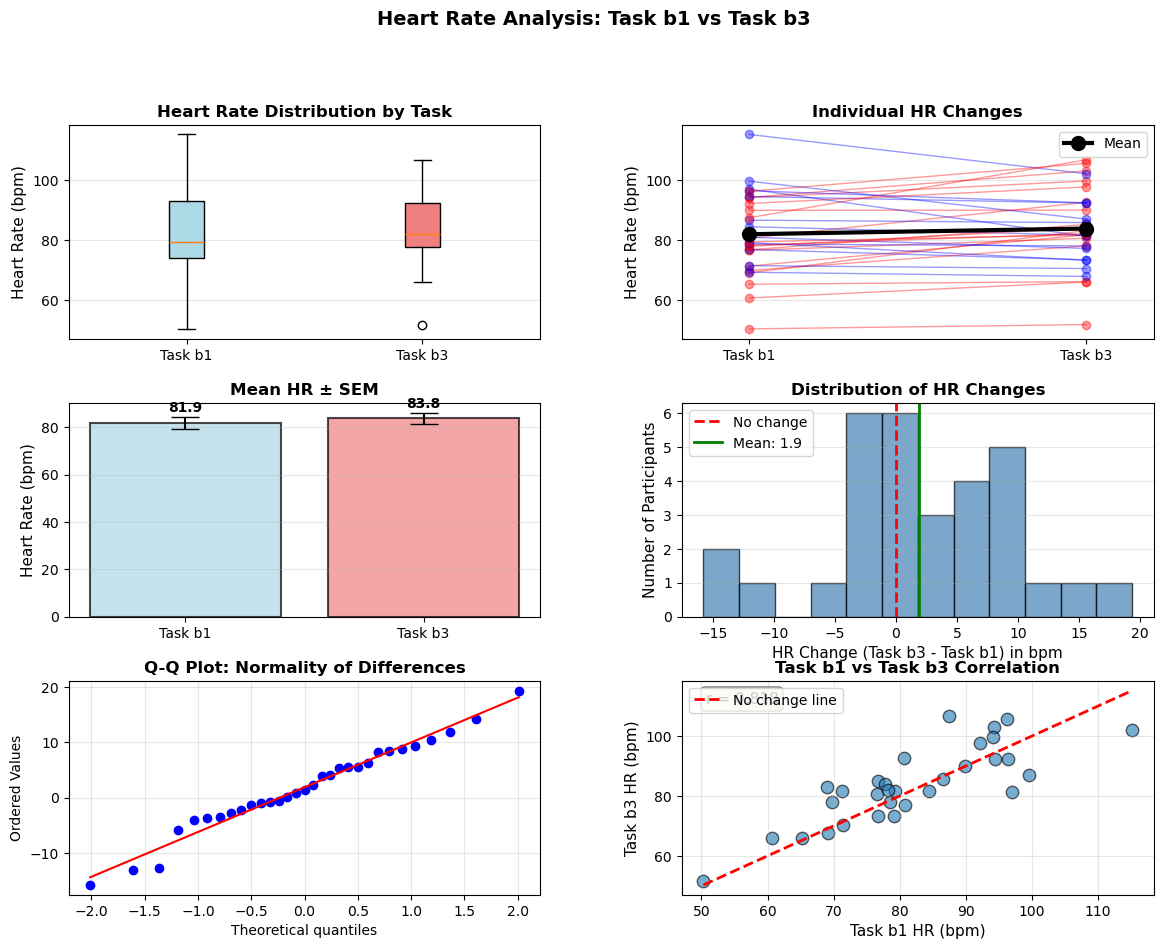


Analysis complete!


In [35]:
# Create the dataframe
data = {
    'Participant': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32],
    'Task_b1': [71.25869, 94.20763, 76.50774, 94.09731, 80.58659, 84.38427, 76.69925, 96.41991, 65.19212, 69.02058, 76.79346, 78.59912, 69.78065, 89.87076, 79.32326, 60.61588, 99.58329, 69.19993, 80.88373, 94.48775, 115.2011, 71.40942, 86.58785, 50.28555, 96.95727, 92.13602, 77.81631, 79.07168, 96.20948, 87.39984, 78.17092],
    'Task_b3': [81.66591, 103.0105, 80.54215, 99.66698, 92.53641, 81.56624, 85.15302, 92.37032, 66.0604, 83.14155, 73.35205, 77.99605, 78.02191, 89.92759, 81.65655, 65.93049, 86.96083, 67.79839, 77.14743, 92.31235, 102.079, 70.42754, 85.76043, 51.72336, 81.18724, 97.68494, 84.05432, 73.16114, 105.5399, 106.7471, 82.11594]
}

df = pd.DataFrame(data)

print("=" * 80)
print("RESEARCH QUESTION: Does task type (b1 vs b3) affect heart rate?")
print("=" * 80)
print(f"\nSample size: n = {len(df)} participants")
print("Study design: Within-subjects (repeated measures)")
print("Dependent variable: Average heart rate (bpm)")
print("Independent variable: Task type (b1 vs b3)")

# ============================================================
# 1. DESCRIPTIVE STATISTICS
# ============================================================
print("\n" + "=" * 80)
print("1. DESCRIPTIVE STATISTICS")
print("=" * 80)

print(f"\nTask b1 (Baseline/Task 1):")
print(f"  Mean HR: {df['Task_b1'].mean():.2f} bpm (SD = {df['Task_b1'].std():.2f})")
print(f"  Median HR: {df['Task_b1'].median():.2f} bpm")
print(f"  Range: {df['Task_b1'].min():.2f} - {df['Task_b1'].max():.2f} bpm")

print(f"\nTask b3 (Experimental/Task 2):")
print(f"  Mean HR: {df['Task_b3'].mean():.2f} bpm (SD = {df['Task_b3'].std():.2f})")
print(f"  Median HR: {df['Task_b3'].median():.2f} bpm")
print(f"  Range: {df['Task_b3'].min():.2f} - {df['Task_b3'].max():.2f} bpm")

# Calculate differences
df['HR_Change'] = df['Task_b3'] - df['Task_b1']
mean_change = df['HR_Change'].mean()
sd_change = df['HR_Change'].std()

print(f"\nHeart Rate Change (Task b3 - Task b1):")
print(f"  Mean change: {mean_change:.2f} bpm (SD = {sd_change:.2f})")
print(f"  Median change: {df['HR_Change'].median():.2f} bpm")
print(f"  Range: {df['HR_Change'].min():.2f} - {df['HR_Change'].max():.2f} bpm")

# Count increases/decreases
increases = (df['HR_Change'] > 0).sum()
decreases = (df['HR_Change'] < 0).sum()
no_change = (df['HR_Change'] == 0).sum()
print(f"\n  Participants with HR increase: {increases} ({increases/len(df)*100:.1f}%)")
print(f"  Participants with HR decrease: {decreases} ({decreases/len(df)*100:.1f}%)")
print(f"  Participants with no change: {no_change}")

# ============================================================
# 2. ASSUMPTION CHECKS
# ============================================================
print("\n" + "=" * 80)
print("2. ASSUMPTION CHECKS FOR PAIRED T-TEST")
print("=" * 80)

# Check normality of DIFFERENCES (key assumption for paired t-test)
shapiro_stat, p_shapiro = stats.shapiro(df['HR_Change'])
print(f"\nShapiro-Wilk Test for Normality of Differences:")
print(f"  W = {shapiro_stat:.4f}, p = {p_shapiro:.4f}")

if p_shapiro > 0.05:
    print(f"  ✓ Differences ARE normally distributed (p > 0.05)")
    print(f"  → Paired t-test is APPROPRIATE")
    use_parametric = True
else:
    print(f"  ✗ Differences are NOT normally distributed (p < 0.05)")
    print(f"  → Consider Wilcoxon signed-rank test instead")
    use_parametric = False

# Check for outliers using IQR method
Q1 = df['HR_Change'].quantile(0.25)
Q3 = df['HR_Change'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['HR_Change'] < Q1 - 1.5*IQR) | (df['HR_Change'] > Q3 + 1.5*IQR)]
print(f"\nOutlier Detection (IQR method):")
print(f"  Number of outliers: {len(outliers)}")
if len(outliers) > 0:
    print(f"  Outlier participants: {outliers['Participant'].tolist()}")
    print(f"  Outlier HR changes: {outliers['HR_Change'].tolist()}")

# ============================================================
# 3. PRIMARY STATISTICAL TEST
# ============================================================
print("\n" + "=" * 80)
print("3. PRIMARY STATISTICAL TEST")
print("=" * 80)

# Paired t-test (parametric)
t_stat, p_value = stats.ttest_rel(df['Task_b1'], df['Task_b3'])

print(f"\nPaired Samples T-Test:")
print(f"  t({len(df)-1}) = {t_stat:.4f}")
print(f"  p-value = {p_value:.4f} {'*' if p_value < 0.05 else ''}")

# 95% Confidence Interval for mean difference
se = stats.sem(df['HR_Change'])
ci = stats.t.interval(0.95, len(df)-1, loc=mean_change, scale=se)
print(f"  95% CI for mean difference: [{ci[0]:.2f}, {ci[1]:.2f}] bpm")

# Interpretation
alpha = 0.05
print(f"\nInterpretation (α = {alpha}):")
if p_value < alpha:
    print(f"  ✓ SIGNIFICANT effect of task on heart rate (p < {alpha})")
    if mean_change > 0:
        print(f"  → Heart rate was significantly HIGHER in Task b3 (+{mean_change:.2f} bpm)")
    else:
        print(f"  → Heart rate was significantly LOWER in Task b3 ({mean_change:.2f} bpm)")
else:
    print(f"  ✗ NO significant effect of task on heart rate (p ≥ {alpha})")
    print(f"  → Tasks b1 and b3 did not produce significantly different heart rates")

# ============================================================
# 4. EFFECT SIZE
# ============================================================
print("\n" + "=" * 80)
print("4. EFFECT SIZE")
print("=" * 80)

# Cohen's d for paired samples
cohens_d = mean_change / sd_change
print(f"\nCohen's d: {cohens_d:.4f}")

if abs(cohens_d) < 0.2:
    effect_size = "negligible"
elif abs(cohens_d) < 0.5:
    effect_size = "small"
elif abs(cohens_d) < 0.8:
    effect_size = "medium"
else:
    effect_size = "large"

print(f"  Interpretation: {effect_size.upper()} effect size")
print(f"\n  Cohen's d benchmarks:")
print(f"    Small: 0.2, Medium: 0.5, Large: 0.8")

# ============================================================
# 5. NON-PARAMETRIC ALTERNATIVE (for robustness)
# ============================================================
print("\n" + "=" * 80)
print("5. NON-PARAMETRIC TEST (for robustness)")
print("=" * 80)

# Wilcoxon signed-rank test
wilcoxon_stat, p_wilcoxon = stats.wilcoxon(df['Task_b1'], df['Task_b3'])

print(f"\nWilcoxon Signed-Rank Test:")
print(f"  Test statistic = {wilcoxon_stat:.4f}")
print(f"  p-value = {p_wilcoxon:.4f} {'*' if p_wilcoxon < 0.05 else ''}")

if p_wilcoxon < alpha:
    print(f"  ✓ SIGNIFICANT effect (p < {alpha})")
else:
    print(f"  ✗ NO significant effect (p ≥ {alpha})")

# ============================================================
# 6. FINAL RECOMMENDATION
# ============================================================
print("\n" + "=" * 80)
print("6. STATISTICAL CONCLUSION")
print("=" * 80)

print(f"\nRecommended test to report: ", end="")
if use_parametric:
    print("PAIRED T-TEST")
    print(f"  Result: t({len(df)-1}) = {t_stat:.3f}, p = {p_value:.4f}, d = {cohens_d:.3f}")
else:
    print("WILCOXON SIGNED-RANK TEST")
    print(f"  Result: W = {wilcoxon_stat:.3f}, p = {p_wilcoxon:.4f}")

print(f"\nConclusion:")
if (use_parametric and p_value < alpha) or (not use_parametric and p_wilcoxon < alpha):
    if mean_change > 0:
        print(f"  Task b3 produced significantly higher heart rates than Task b1")
        print(f"  (Mean increase: {mean_change:.2f} bpm, Effect size: {effect_size})")
    else:
        print(f"  Task b3 produced significantly lower heart rates than Task b1")
        print(f"  (Mean decrease: {abs(mean_change):.2f} bpm, Effect size: {effect_size})")
else:
    print(f"  No significant difference in heart rate between tasks")
    print(f"  (Mean difference: {mean_change:.2f} bpm, p = {p_value:.4f})")

# ============================================================
# 7. VISUALIZATIONS
# ============================================================
print("\n" + "=" * 80)
print("Generating visualizations...")
print("=" * 80)

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Boxplot comparison
ax1 = fig.add_subplot(gs[0, 0])
box_data = [df['Task_b1'], df['Task_b3']]
bp = ax1.boxplot(box_data, labels=['Task b1', 'Task b3'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
ax1.set_ylabel('Heart Rate (bpm)', fontsize=11)
ax1.set_title('Heart Rate Distribution by Task', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# 2. Individual participant changes
ax2 = fig.add_subplot(gs[0, 1])
for i in range(len(df)):
    color = 'red' if df.iloc[i]['HR_Change'] > 0 else 'blue'
    ax2.plot([1, 2], [df.iloc[i]['Task_b1'], df.iloc[i]['Task_b3']],
             'o-', alpha=0.4, color=color, linewidth=1)
ax2.plot([1, 2], [df['Task_b1'].mean(), df['Task_b3'].mean()],
         'ko-', linewidth=3, markersize=10, label='Mean')
ax2.set_xlim(0.8, 2.2)
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['Task b1', 'Task b3'])
ax2.set_ylabel('Heart Rate (bpm)', fontsize=11)
ax2.set_title('Individual HR Changes', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. Bar plot with error bars
ax3 = fig.add_subplot(gs[1, 0])
means = [df['Task_b1'].mean(), df['Task_b3'].mean()]
sems = [stats.sem(df['Task_b1']), stats.sem(df['Task_b3'])]
bars = ax3.bar(['Task b1', 'Task b3'], means, yerr=sems,
               capsize=10, alpha=0.7, color=['lightblue', 'lightcoral'],
               edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Heart Rate (bpm)', fontsize=11)
ax3.set_title('Mean HR ± SEM', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
# Add values on bars
for i, (bar, mean) in enumerate(zip(bars, means)):
    ax3.text(bar.get_x() + bar.get_width()/2, mean + sems[i] + 1,
             f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

# 4. Distribution of HR changes
ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(df['HR_Change'], bins=12, edgecolor='black', alpha=0.7, color='steelblue')
ax4.axvline(0, color='red', linestyle='--', linewidth=2, label='No change')
ax4.axvline(mean_change, color='green', linestyle='-', linewidth=2, label=f'Mean: {mean_change:.1f}')
ax4.set_xlabel('HR Change (Task b3 - Task b1) in bpm', fontsize=11)
ax4.set_ylabel('Number of Participants', fontsize=11)
ax4.set_title('Distribution of HR Changes', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 5. Q-Q plot for normality check
ax5 = fig.add_subplot(gs[2, 0])
stats.probplot(df['HR_Change'], dist="norm", plot=ax5)
ax5.set_title('Q-Q Plot: Normality of Differences', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

# 6. Scatter plot with regression line
ax6 = fig.add_subplot(gs[2, 1])
ax6.scatter(df['Task_b1'], df['Task_b3'], alpha=0.6, s=80, edgecolor='black')
# Add diagonal line (no change)
min_val = min(df['Task_b1'].min(), df['Task_b3'].min())
max_val = max(df['Task_b1'].max(), df['Task_b3'].max())
ax6.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='No change line')
# Add correlation
corr, _ = stats.pearsonr(df['Task_b1'], df['Task_b3'])
ax6.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax6.transAxes,
         fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax6.set_xlabel('Task b1 HR (bpm)', fontsize=11)
ax6.set_ylabel('Task b3 HR (bpm)', fontsize=11)
ax6.set_title('Task b1 vs Task b3 Correlation', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.suptitle('Heart Rate Analysis: Task b1 vs Task b3', fontsize=14, fontweight='bold', y=0.995)
plt.show()

print("\n" + "=" * 80)
print("Analysis complete!")
print("=" * 80)